In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class NArmedBandit:
    def __init__(self, n=10, epsilon=0):
        self.n = n
        self.epsilon = epsilon
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)
        self.actions = []
        self.rewards = []

    def take_action(self):
        if self.epsilon > random.uniform(0, 1):
            # Explore
            selected_action = np.random.choice(range(self.n))
        else:
            # Exploit
            estimated_action_values = [self.estimated_value(action) for action in range(self.n)]
            max_value = np.max(estimated_action_values)
            ties = np.where(estimated_action_values == max_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax

        reward = self.reward(selected_action)

        self.actions.append(selected_action)
        self.rewards.append(reward)

        return selected_action, reward

    def optimal_action(self):
        return np.argmax(self.action_values)

    def estimated_value(self, action):
        if self.N(action) == 0:
            return 0
        else:
            previous_occurences = np.array(self.actions) == action
            sum_previous_rewards = np.array(self.rewards)[previous_occurences].sum()
            return sum_previous_rewards / self.N(action)

    def N(self, action):
        return self.actions.count(action)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)


In [6]:
bandits = [NArmedBandit(epsilon=0) for _ in range(100)]

In [7]:
reward_matrix = np.zeros((100, 1000))
optimal_action_matrix = np.zeros((100, 1000))

for bandit_index, bandit in tqdm(enumerate(bandits)):
    for step in range(1000):
        action, reward = bandit.take_action()
        reward_matrix[bandit_index, step] = reward
        optimal_action_matrix[bandit_index, step] = (1 if action == bandit.optimal_action() else 0)

100it [01:22,  1.22it/s]


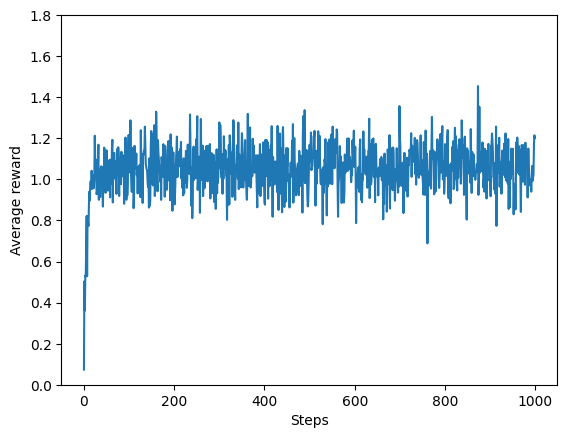

In [8]:
reward_averages= np.mean(reward_matrix, axis=0)
plt.plot(reward_averages)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.ylim(0, 1.8)
plt.grid(False)
plt.show()

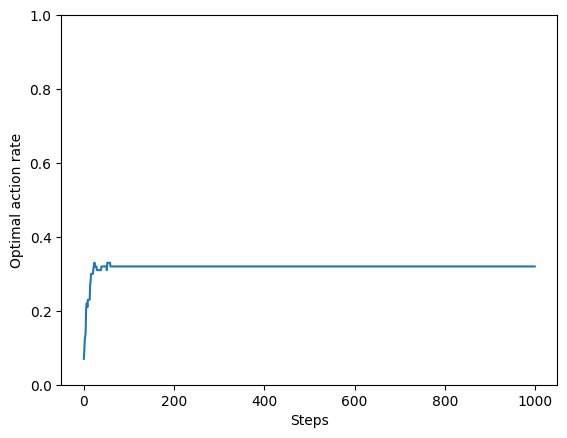

In [10]:
optimal_action_averages = np.mean(optimal_action_matrix, axis=0)
plt.plot(optimal_action_averages)
plt.xlabel("Steps")
plt.ylabel("Optimal action rate")
plt.ylim(0, 1)
plt.grid(False)
plt.show()

In [11]:
class NArmedBanditIncremental:
    def __init__(self, n=10, epsilon=0):
        self.n = n
        self.epsilon = epsilon
        self.incremental_estimated_action_values = np.zeros(n)
        self.last_reward = 0
        self.action_counts = np.zeros(n)
        self.action_values = np.random.normal(loc=0.0, scale=1.0, size=n)

    def take_action(self):
        exploit = (random.uniform(0, 1) >= self.epsilon)

        if exploit:
            max_estimated_action_value = np.max(self.incremental_estimated_action_values)
            ties = np.where(self.incremental_estimated_action_values == max_estimated_action_value)[0]
            random_argmax = np.random.choice(ties)
            selected_action = random_argmax
        else:
            selected_action = np.random.choice(range(self.n))

        self.action_counts[selected_action] += 1
        self.last_reward = self.reward(selected_action)

        self.update_incremental_estimated_action_values(selected_action)

        return selected_action, self.last_reward

    def optimal_action(self):
        return np.argmax(self.action_values)

    def update_incremental_estimated_action_values(self, action):
        k = self.action_counts[action]
        Q_k = self.incremental_estimated_action_values[action]
        R_k = self.last_reward
        self.incremental_estimated_action_values[action] = Q_k + (1 / k) * (R_k - Q_k)

    def reward(self, action):
        return self.action_values[action] + np.random.normal(loc=0.0, scale=1.0)


In [12]:
bandit = NArmedBanditIncremental(epsilon=0.1)

In [13]:
bandit.incremental_estimated_action_values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
bandit.take_action()

(np.int64(1), np.float64(0.43396563304857105))

In [15]:
bandit.incremental_estimated_action_values

array([0.        , 0.43396563, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [16]:
bandit.take_action()

(np.int64(1), np.float64(0.9313616518962918))

In [17]:
bandit.incremental_estimated_action_values

array([0.        , 0.68266364, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [18]:
bandit.action_counts

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
class BanditAnalysis:
    def __init__(self, bandits, steps=1000):
        self.bandits = bandits
        self.reward_matrix = np.zeros((len(bandits), steps))
        self.optimal_action_matrix = np.zeros((len(bandits), steps))

    def fill(self):
        for bandit_index, bandit in tqdm(enumerate(self.bandits)):
            for step in range(1000):
                action, reward = bandit.take_action()
                self.reward_matrix[bandit_index, step] = reward
                self.optimal_action_matrix[bandit_index, step] = (1 if action == bandit.optimal_action() else 0)

    def plot_reward_averages(self, color, show=False):
        reward_averages= np.mean(self.reward_matrix, axis=0)
        plt.plot(reward_averages, color=color)
        plt.xlabel("Steps")
        plt.ylabel("Average reward")
        plt.ylim(0, 1.8)
        plt.grid(False)
        if show: plt.show()

    def plot_optimal_action_averages(self, color, show=False):
        optimal_action_averages = np.mean(self.optimal_action_matrix, axis=0)
        plt.plot(optimal_action_averages, color=color)
        plt.xlabel("Steps")
        plt.ylabel("Optimal action rate")
        plt.ylim(0, 1)
        plt.grid(False)
        if show: plt.show()
        

In [20]:
bandits_0 = [NArmedBanditIncremental(epsilon=0) for _ in range(2000)]
bandits_001 = [NArmedBanditIncremental(epsilon=0.01) for _ in range(2000)]
bandits_01 = [NArmedBanditIncremental(epsilon=0.1) for _ in range(2000)]

In [21]:
bandit_analysis_0 = BanditAnalysis(bandits_0)
bandit_analysis_001 = BanditAnalysis(bandits_001)
bandit_analysis_01 = BanditAnalysis(bandits_01)

In [22]:
bandit_analysis_0.fill()
bandit_analysis_001.fill()
bandit_analysis_01.fill()

2000it [01:58, 16.89it/s]
2000it [01:58, 16.89it/s]
2000it [01:56, 17.10it/s]


In [23]:
bandit = bandit_analysis_01.bandits[0]

In [24]:
bandit.action_counts

array([ 11.,  24.,  11., 299.,  13.,  13.,  15.,  12.,   9., 593.])

In [25]:
bandit.incremental_estimated_action_values

array([-1.5093664 ,  0.3222981 , -1.23077725,  1.02701256, -1.88302655,
       -0.32786239,  0.84038656, -1.39884117,  0.05051159,  0.90965075])

In [26]:
bandit.action_values

array([-1.4512864 ,  0.24745023, -1.04435565,  1.00233481, -1.83129567,
       -0.34545333,  0.89061659, -1.40964808,  0.08295465,  0.89714722])

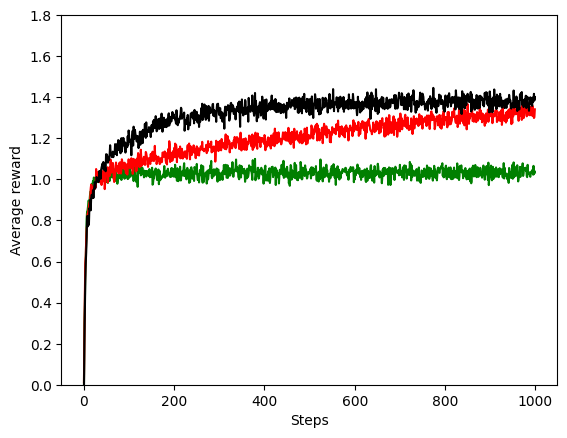

In [27]:
bandit_analysis_0.plot_reward_averages(color="green")
bandit_analysis_001.plot_reward_averages(color="red")
bandit_analysis_01.plot_reward_averages(color="black")


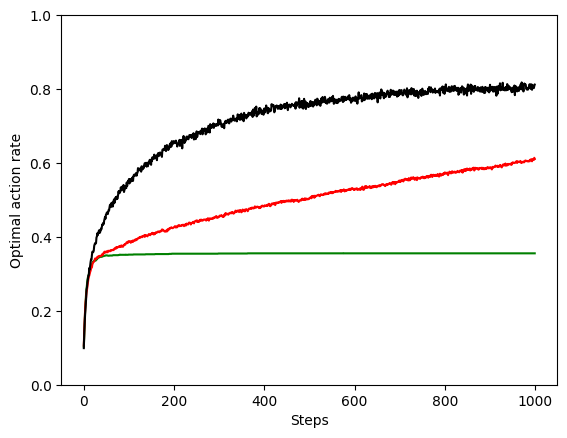

In [28]:
bandit_analysis_0.plot_optimal_action_averages(color="green")
bandit_analysis_001.plot_optimal_action_averages(color="red")
bandit_analysis_01.plot_optimal_action_averages(color="black")